In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from scipy.optimize import curve_fit
from collections import defaultdict
from scipy.spatial.distance import cdist
mpl.rcParams['axes.linewidth'] = 2
from DEPENDENCIES.recycle import *
from svg2emf import svg2emf

In [4]:
def multi_map_xy(xy, multi_var, nres=50, L=13, nneigh=3):
    dx, dy = L/nres, L/nres
    X, Y = np.arange(0,L,dx), np.arange(0,L,dy)
    frame = np.zeros((len(multi_var[0]), nres, nres))
    for i, y in enumerate(Y):
        for j, x in enumerate(X):
            dists = cdist([[x+0.5*dx,y+0.5*dy]], xy)
            ndx = np.argsort(dists[0])[:nneigh]
            frame[:,i,j] = np.mean(multi_var[ndx,:], axis=0)
    return frame

def read_text_order_xy_map(fname, tini=0, tfin=1000000, nres=50, L=13, dt=800):
    f = open(fname, "r")
    fl = f.readlines()
    f.close()
    
    time = -1
    data, vals = [], []
    for line in fl:
        if "#T - >" in line:
            if vals != []:
                vals = np.array(vals, dtype='float')
                data.append(multi_map_xy(vals[:,:2], vals[:,2:], nres=nres, L=L)) 
            time = int(float(line.split()[3]))
            vals = []
        if time >= tini and time <= tfin and time%dt==0:
            if "#" not in line and "@" not in line:
                vals.append(line.split())
    data = np.array(data)
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    print("Done with {}".format(fname))
    return data_mean, data_std

In [5]:
def average_multimap(spaces, rad_px, mid_pxs=None, dec=3):
    aves, stds = [], []
    for space in spaces:
        if mid_pxs == None:
            mid_px_x, mid_px_y = len(space)//2, len(space)//2
        else:
            mid_px_x, mid_px_y = mid_pxs[0], mid_pxs[1]
        X, Y = np.meshgrid(np.linspace(0,len(space)-1, len(space)), np.linspace(0,len(space)-1, len(space)))
        NDX = ((X-mid_px_x)**2 + (Y-mid_px_y)**2)**0.5
        mask = NDX <= rad_px
        ave, std = np.mean(space[mask]), np.std(space[mask])
        aves.append(ave)
        stds.append(std)
        print("{} +/- {}". format(np.round(ave, dec), np.round(std, dec)))
    return aves, stds

In [6]:
def plot_order_bead(ref_means, ref_stds, means, stds):
    bead = np.linspace(1,4,4)
    chains = ['sn2', 'sn1']
    colors = [(0.2,0.6,1.0), (1.0,0.6,0.2)]
    fig, axs = plt.subplots(figsize=(12,5), ncols=2, subplot_kw={'xlim':(0,5), 'ylim':(0,1)}, gridspec_kw={'wspace':0.4})
    for ax, ref_mean, ref_std, mean, std in zip(axs, ref_means, ref_stds, means, stds):
        ax.tick_params(labelsize=Z)
        ax.set_xlabel("Tail bead ID", fontsize=Z)
        ax.set_ylabel("Order parameter", fontsize=Z)
        ax.set_xticks(bead)
        for i1,i2, c, chain in zip([0,4], [4,8], colors, chains):
            ax.errorbar(bead, ref_mean[i1:i2], yerr=ref_std[i1:i2], fmt='o-', mew=1, ms=7, mec='k', capsize=4, lw=2, c=c, ls='--', label='{} Ref'.format(chain))
            ax.errorbar(bead, mean[i1:i2], yerr=std[i1:i2], fmt='o-', mew=1, ms=7, mec='k', capsize=4, lw=2, c=c, ls='-', label='{} Perturb'.format(chain))
            
        ax.legend(fontsize=Z-4, loc='lower left')
    plt.show()

In [7]:
def plot_order(orders, means, cmap='seismic', delta=0.2, fname='tmp'):
    fig, axs = plt.subplots(figsize=(20,20), ncols=4, nrows=4, subplot_kw={'xticks':[0,24,49], 'yticks':[0,24,49], 'xticklabels':['-7.0','0.0','+7.0'], 'yticklabels':['+7.0','0.0','-7.0']}, gridspec_kw={'wspace':0.45, 'hspace':0.45})
    axa = [axs[:,:2], axs[:,2:]]
    for order, mean, axb in zip(orders, means, axa):
        for i in range(len(axb[0,:])):
            for orde, ave, ax in zip(order[i*4:(i+1)*4], mean[i*4:(i+1)*4], axb.T[i]):
                ax.tick_params(labelsize=Z)
                ax.set_xlabel("X-axis (nm)", fontsize=Z)
                ax.set_ylabel("Y-axis (nm)", fontsize=Z)
                cax = ax.imshow(orde, cmap=cmap, vmin=ave-delta, vmax=ave+delta, interpolation='bilinear')
    a = plt.axes([0.95, 0.53, 0.02, 0.35])
    cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[ave-delta,ave,ave+delta])
    cbar.ax.set_yticklabels(["-{:.1f}".format(delta), "Mean", "+{:.1f}".format(delta)])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Order parameter", fontsize=Z)
    plt.savefig("Plots/{}_order_beadmap.png".format(fname), format='png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()

In [8]:
plot_order(n0_ords, [p5_means, p6_means], fname='NP0', delta=0.3)

NameError: name 'n0_ords' is not defined

In [9]:
p5_ord, p5_ord_std = read_text_order_xy_map("ORDER/POPC5-35_PRO1_order_xy.sfu", tini=0, tfin=1000000, dt=3600, L=15)
p6_ord, p6_ord_std = read_text_order_xy_map("ORDER/POPC6-35_PRO1_order_xy.sfu", tini=0, tfin=1000000, dt=3600, L=12)
g5_ord, g5_ord_std = read_text_order_xy_map("ORDER/gH-POPC5-46_PRO1_order_xy.sfu", tini=780000, tfin=1000000, dt=3600, L=15)
g6_ord, g6_ord_std = read_text_order_xy_map("ORDER/gH-POPC6-46_PRO1_order_xy.sfu", tini=50000, tfin=1000000, dt=3600, L=11)
n05_ord, n05_ord_std = read_text_order_xy_map("ORDER/NP610-POPC5-46_PRO1-8_order_xy.sfu", tini=1329000, tfin=2000000, dt=3600, L=15)
n06_ord, n06_ord_std = read_text_order_xy_map("ORDER/NP610-POPC6-46_PRO1_order_xy.sfu", tini=215000, tfin=1000000, dt=3600, L=12)
n15_ord, n15_ord_std = read_text_order_xy_map("ORDER/NP61-POPC5-46_PRO3_order_xy.sfu", tini=2895000, tfin=3000000, dt=3600, L=15)
n161_ord, n161_ord_std = read_text_order_xy_map("ORDER/NP61-POPC6-46_PRO1_order_xy.sfu", tini=126000, tfin=864000, dt=3600, L=12)
n162_ord, n162_ord_std = read_text_order_xy_map("ORDER/NP61-POPC6-46_PRO1_order_xy.sfu", tini=864000, tfin=1000000, dt=3600, L=12)

Done with ORDER/POPC5-35_PRO1_order_xy.sfu
Done with ORDER/POPC6-35_PRO1_order_xy.sfu
Done with ORDER/gH-POPC5-46_PRO1_order_xy.sfu
Done with ORDER/gH-POPC6-46_PRO1_order_xy.sfu
Done with ORDER/NP610-POPC5-46_PRO1-8_order_xy.sfu
Done with ORDER/NP610-POPC6-46_PRO1_order_xy.sfu
Done with ORDER/NP61-POPC5-46_PRO3_order_xy.sfu
Done with ORDER/NP61-POPC6-46_PRO1_order_xy.sfu
Done with ORDER/NP61-POPC6-46_PRO1_order_xy.sfu


In [10]:
print('POPC')
p5_means, p5_stds = average_multimap(p5_ord, 1000)
print('POPC:CHOL')
p6_means, p6_stds = average_multimap(p6_ord, 1000)
print("POPC -> gH-local")
g5_means, g5_stds = average_multimap(g5_ord, 6)
print("POPC:CHOL -> gH-local")
g6_means, g6_stds = average_multimap(g6_ord, 6)
print("POPC -> NP0-local")
n05_means, n05_stds = average_multimap(n05_ord, 6)
print("POPC:CHOL -> NP0-local")
n06_means, n06_stds = average_multimap(n06_ord, 6)
print("POPC -> gHNP-local")
n15_means, n15_stds = average_multimap(n15_ord, 6)
print("POPC:CHOL -> gHNP-local (Binding mode 1)")
n161_means, n161_stds = average_multimap(n161_ord, 6)
print("POPC:CHOL -> gHNP-local (Binding mode 2)")
n162_means, n162_stds = average_multimap(n162_ord, 6)

POPC
0.707 +/- 0.009
0.551 +/- 0.012
0.482 +/- 0.013
0.267 +/- 0.018
0.626 +/- 0.011
0.575 +/- 0.012
0.514 +/- 0.013
0.358 +/- 0.015
POPC:CHOL
0.701 +/- 0.009
0.607 +/- 0.013
0.711 +/- 0.015
0.61 +/- 0.017
0.649 +/- 0.01
0.76 +/- 0.011
0.788 +/- 0.012
0.638 +/- 0.016
POPC -> gH-local
0.734 +/- 0.023
0.578 +/- 0.017
0.47 +/- 0.028
0.219 +/- 0.038
0.647 +/- 0.018
0.6 +/- 0.022
0.506 +/- 0.033
0.333 +/- 0.054
POPC:CHOL -> gH-local
0.724 +/- 0.01
0.607 +/- 0.014
0.645 +/- 0.037
0.512 +/- 0.042
0.675 +/- 0.012
0.743 +/- 0.014
0.725 +/- 0.028
0.569 +/- 0.024
POPC -> NP0-local
0.656 +/- 0.019
0.431 +/- 0.068
0.322 +/- 0.124
0.185 +/- 0.1
0.631 +/- 0.026
0.504 +/- 0.092
0.413 +/- 0.126
0.342 +/- 0.092
POPC:CHOL -> NP0-local
0.571 +/- 0.016
0.344 +/- 0.032
0.224 +/- 0.072
0.103 +/- 0.08
0.55 +/- 0.032
0.397 +/- 0.083
0.336 +/- 0.112
0.263 +/- 0.109
POPC -> gHNP-local
0.677 +/- 0.047
0.531 +/- 0.054
0.548 +/- 0.088
0.4 +/- 0.106
0.635 +/- 0.049
0.603 +/- 0.091
0.585 +/- 0.125
0.46 +/- 0.12
POPC:

In [11]:
p_ords = [p5_ord, p6_ord]
g_ords = [g5_ord, g6_ord]
n0_ords = [n05_ord, n06_ord]
n11_ords = [n15_ord, n161_ord]
n12_ords = [n15_ord, n162_ord]

gH with/without cholesterol


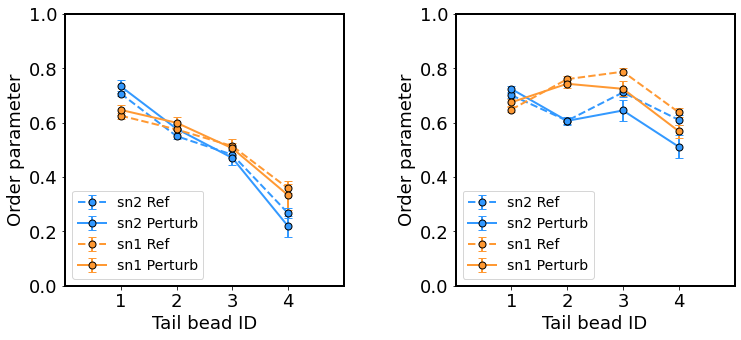

NP0 with/without cholesterol


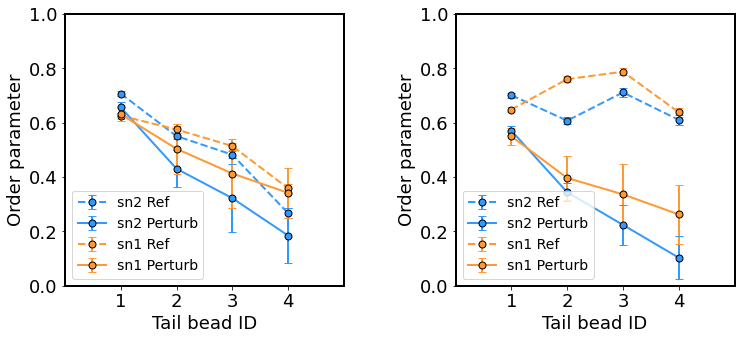

gHNP with/without cholesterol (Binding mode 1)


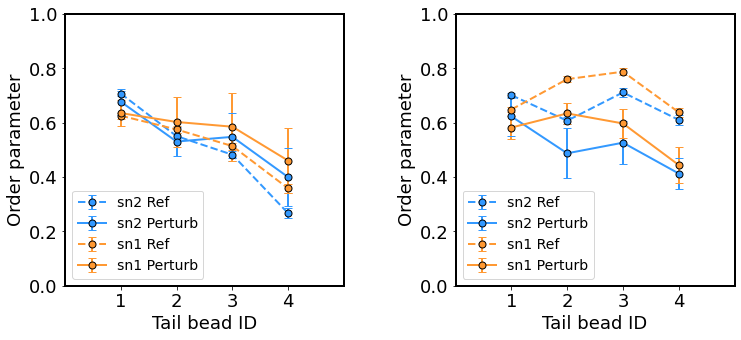

gHNP with/without cholesterol (Binding mode 2)


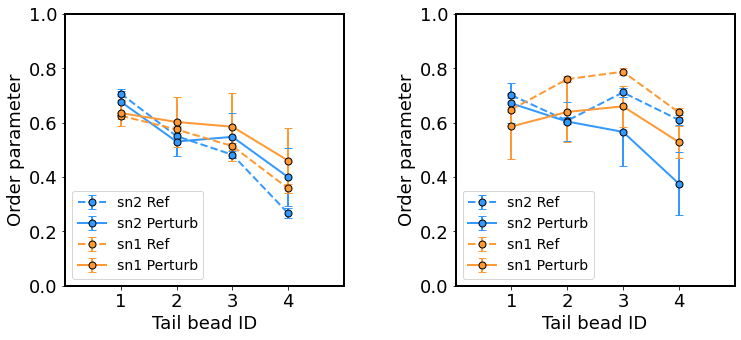

In [12]:
print("gH with/without cholesterol")
plot_order_bead([p5_means, p6_means], [p5_stds, p6_stds], [g5_means, g6_means], [g5_stds, g6_stds])
print("NP0 with/without cholesterol")
plot_order_bead([p5_means, p6_means], [p5_stds, p6_stds], [n05_means, n06_means], [n05_stds, n06_stds])
print("gHNP with/without cholesterol (Binding mode 1)")
plot_order_bead([p5_means, p6_means], [p5_stds, p6_stds], [n15_means, n161_means], [n15_stds, n161_stds])
print("gHNP with/without cholesterol (Binding mode 2)")
plot_order_bead([p5_means, p6_means], [p5_stds, p6_stds], [n15_means, n162_means], [n15_stds, n162_stds])

POPC/POPC:CHOL


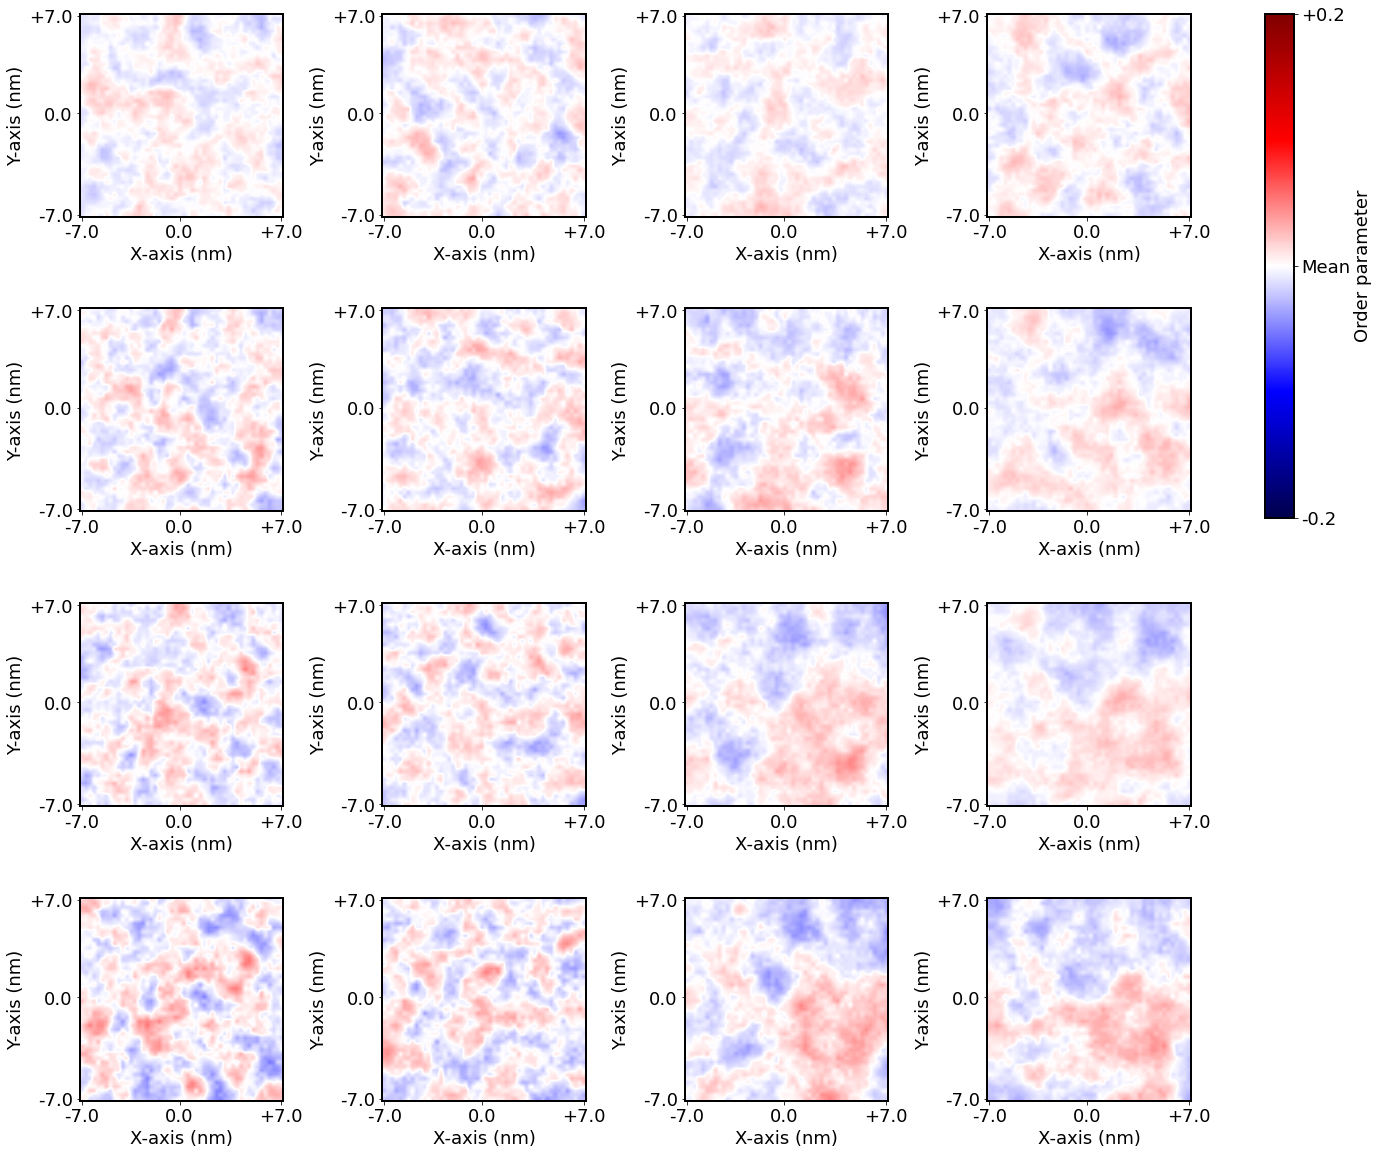

gH with/without cholesterol


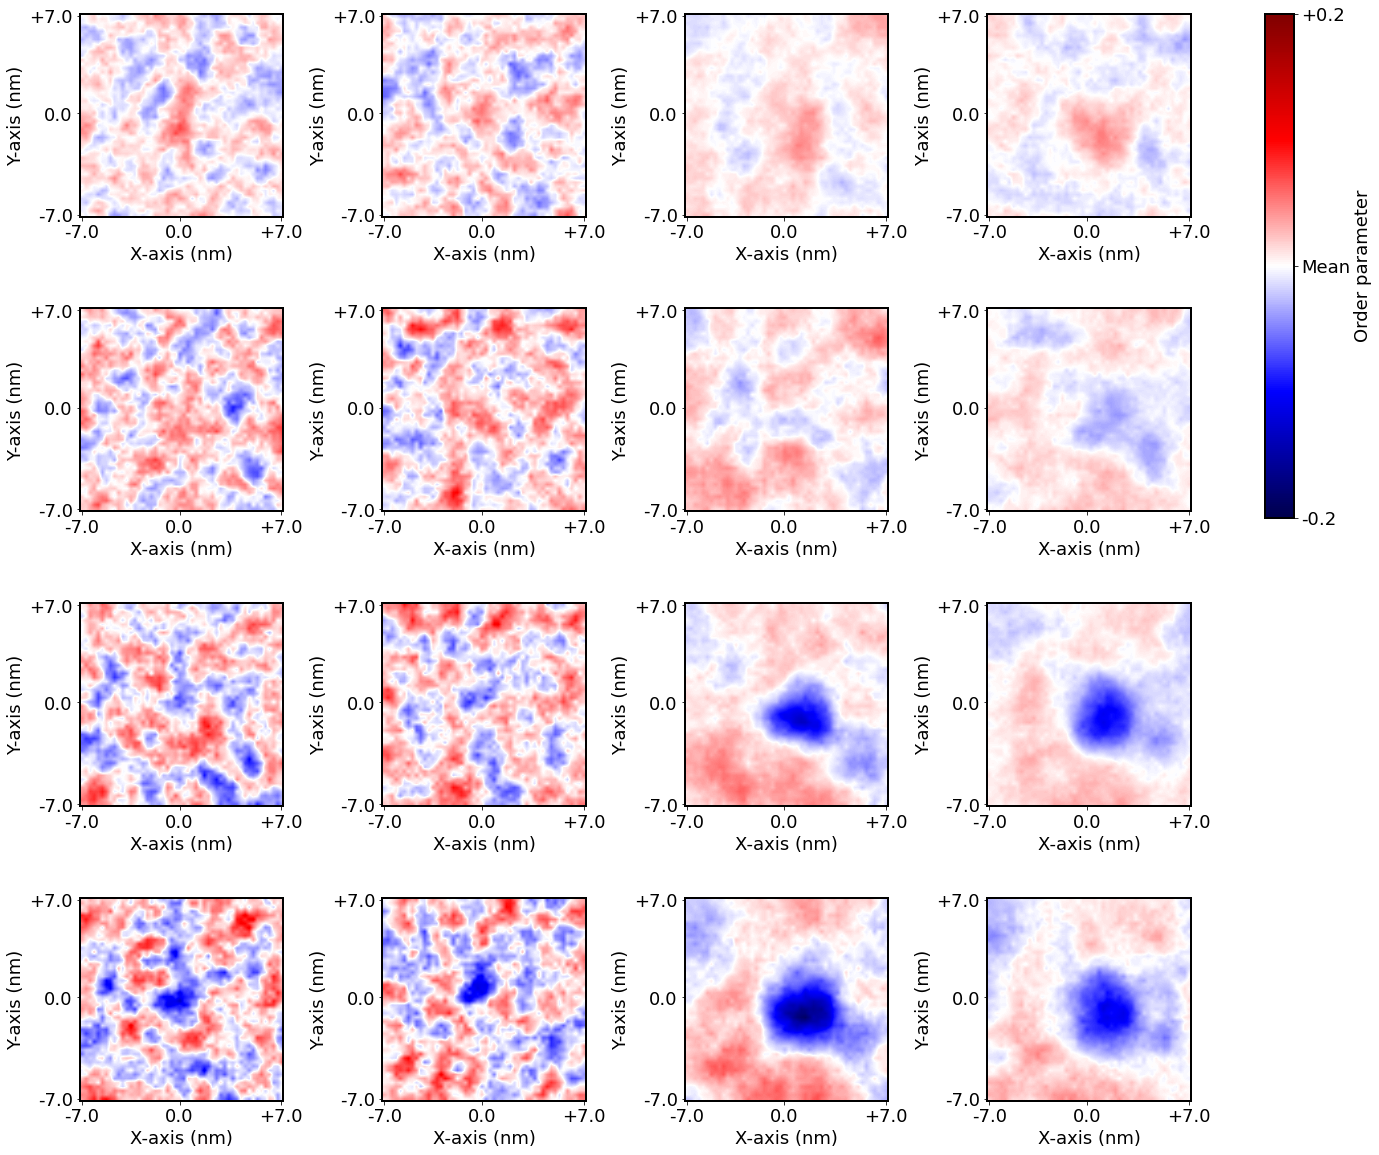

NP0 with/without cholesterol


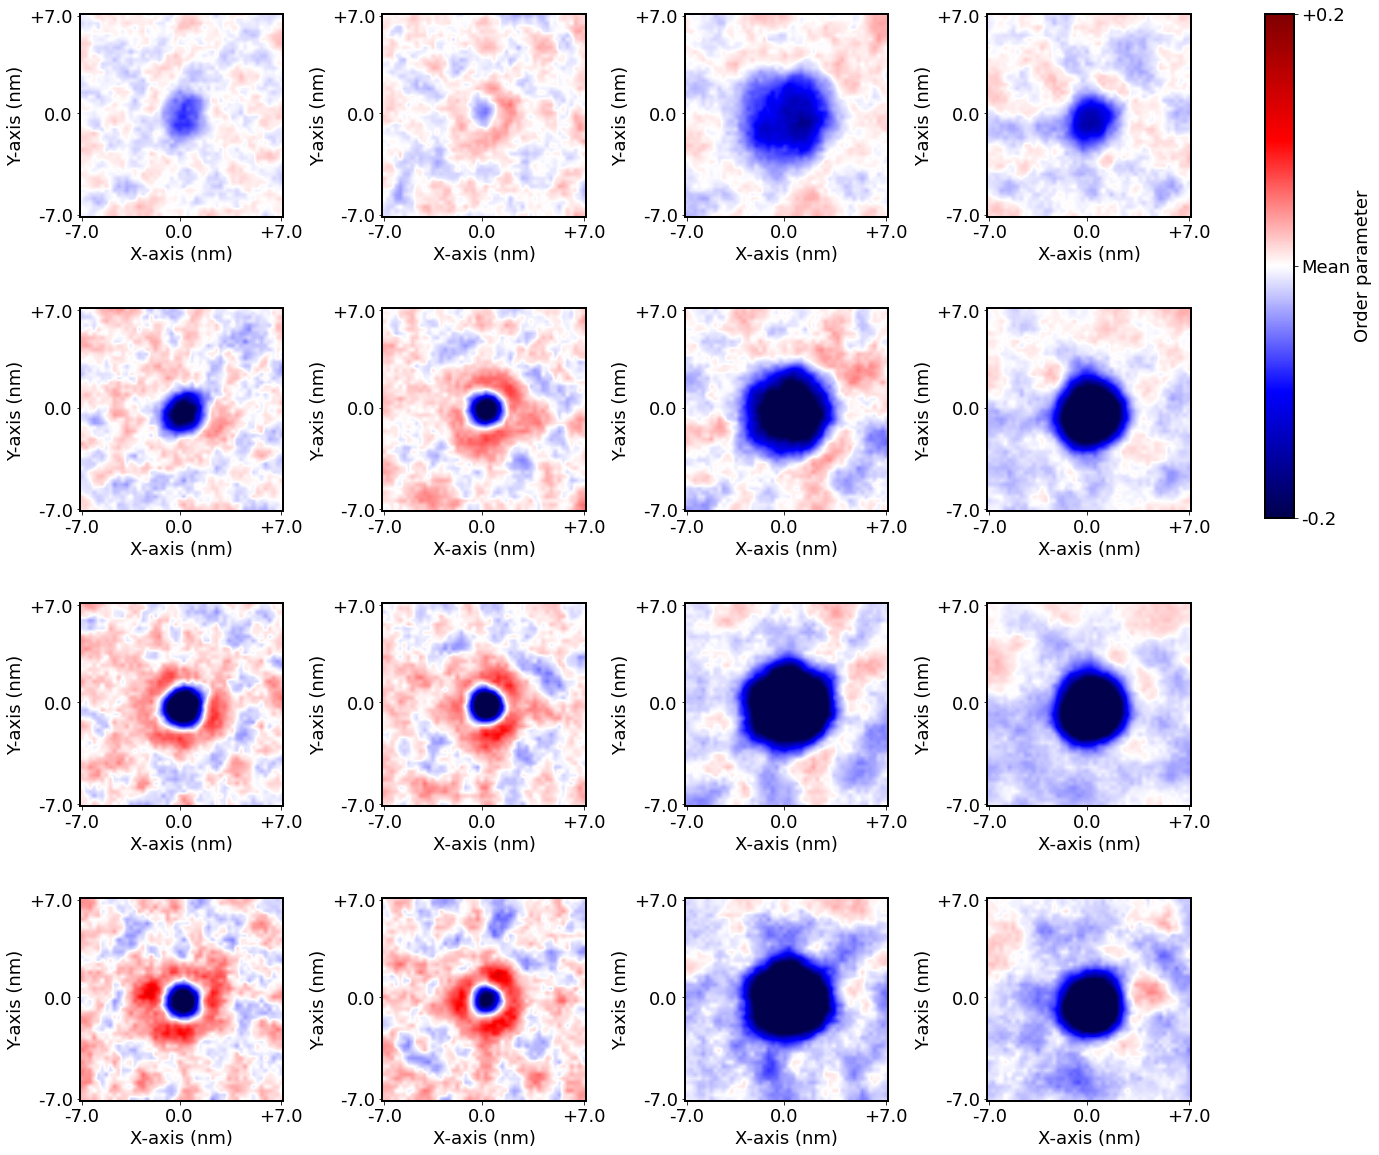

gHNP with/without cholesterol (Binding mode 1)


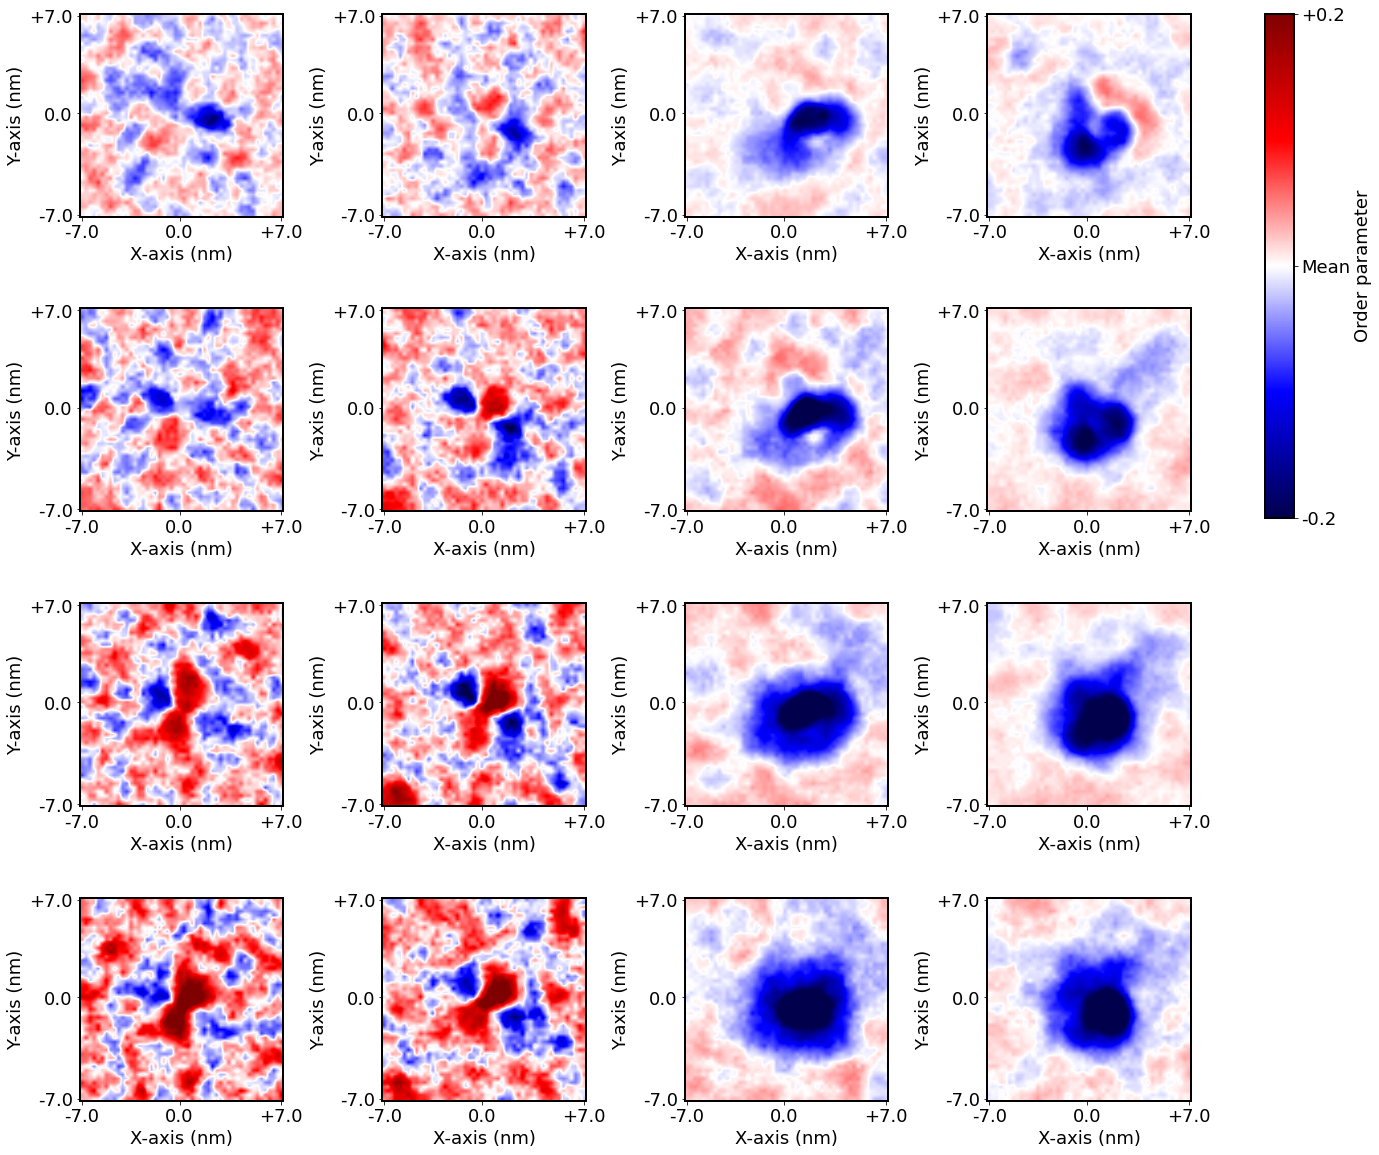

gHNP with/without cholesterol (Binding mode 2)


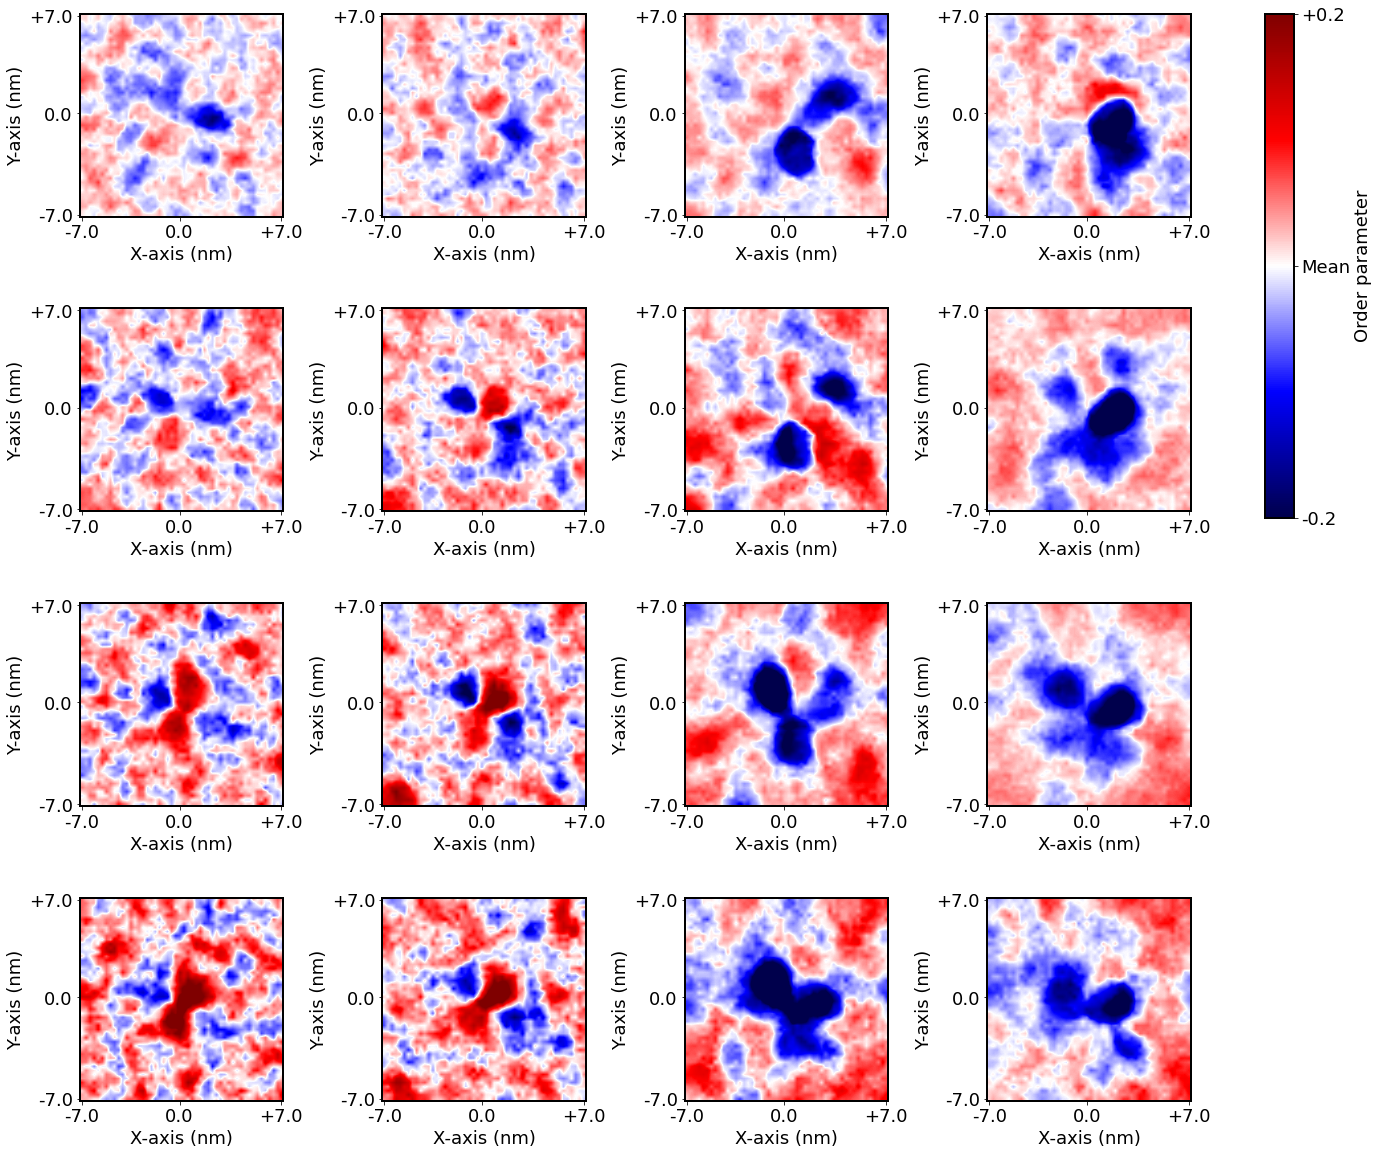

In [13]:
print("POPC/POPC:CHOL")
plot_order(p_ords, [p5_means, p6_means])
print("gH with/without cholesterol")
plot_order(g_ords, [p5_means, p6_means])
print("NP0 with/without cholesterol")
plot_order(n0_ords, [p5_means, p6_means])
print("gHNP with/without cholesterol (Binding mode 1)")
plot_order(n11_ords, [p5_means, p6_means])
print("gHNP with/without cholesterol (Binding mode 2)")
plot_order(n12_ords, [p5_means, p6_means])

In [14]:
def plot_order_mean(orders, means, cmap='seismic', delta=0.2, fname='tmp'):
    fig, axs = plt.subplots(figsize=(9,3), ncols=2, subplot_kw={'xticks':[0,24,49], 'yticks':[0,24,49], 'xticklabels':['-7.0','0.0','+7.0'], 'yticklabels':['+7.0','0.0','-7.0']}, gridspec_kw={'wspace':0.4})
    for ax, order, mean in zip(axs, orders, means):
        ax.tick_params(labelsize=Z)
        ax.set_xlabel("X-axis (nm)", fontsize=Z)
        ax.set_ylabel("Y-axis (nm)", fontsize=Z)
        flat = np.mean(order, axis=0)
        flat_mean, flat_std = np.mean(mean), np.std(mean)
        print("{:.3f} +/- {:.3f}".format(flat_mean, flat_std))
        cax = ax.imshow(flat.T, cmap=cmap, vmin=flat_mean-delta, vmax=flat_mean+delta, interpolation='bilinear')
        #cax = ax.imshow(flat.T, cmap=cmap, vmin=-0.5, vmax=1, interpolation='bilinear')

    a = plt.axes([0.95, 0.175, 0.04, 0.65])
    cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[flat_mean-delta,flat_mean,flat_mean+delta])
    #cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[-0.5,0,0.5,1])
    cbar.ax.set_yticklabels(["-{:.1f}".format(delta), "Mean", "+{:.1f}".format(delta)])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Mean order parameter", fontsize=Z)
    plt.savefig("Plots/{}_order.png".format(fname), format='png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()

0.510 +/- 0.133
0.683 +/- 0.063


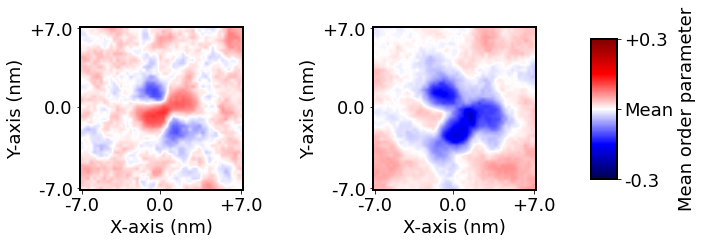

In [15]:
#plot_order_mean(n0_ords, [p5_means, p6_means], delta = 0.32, fname='NP0', cmap='seismic')
plot_order_mean(n12_ords, [p5_means, p6_means], delta = 0.32, fname='gHNP', cmap='seismic')

POPC/POPC:CHOL
0.510 +/- 0.133
0.683 +/- 0.063


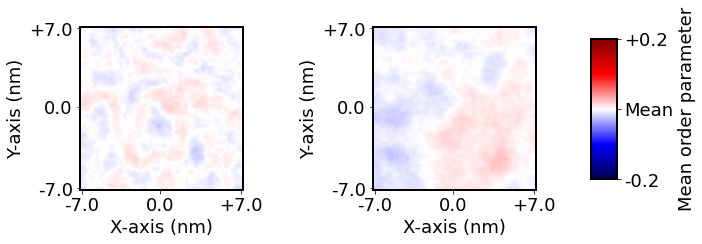

gH with/without cholesterol
0.510 +/- 0.133
0.683 +/- 0.063


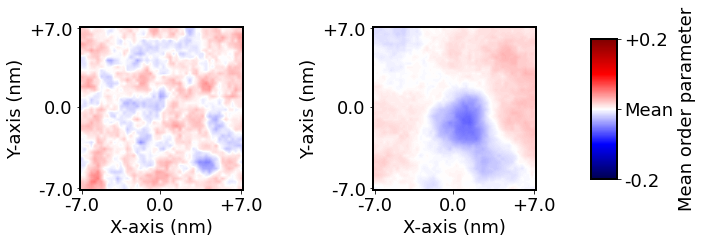

NP0 with/without cholesterol
0.510 +/- 0.133
0.683 +/- 0.063


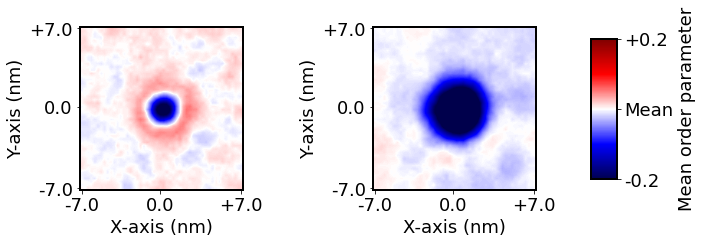

gHNP with/without cholesterol (Binding mode 1)
0.510 +/- 0.133
0.683 +/- 0.063


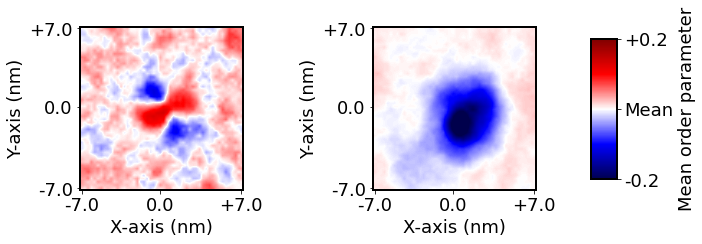

gHNP with/without cholesterol (Binding mode 2)
0.510 +/- 0.133
0.683 +/- 0.063


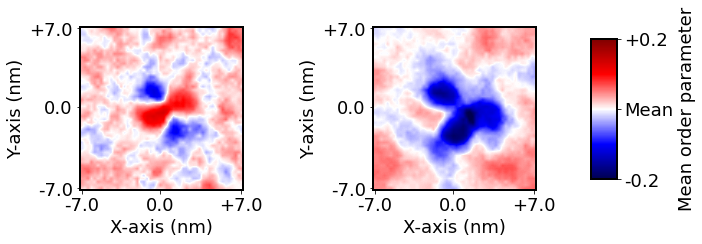

In [16]:
print("POPC/POPC:CHOL")
plot_order_mean(p_ords, [p5_means, p6_means])
print("gH with/without cholesterol")
plot_order_mean(g_ords, [p5_means, p6_means])
print("NP0 with/without cholesterol")
plot_order_mean(n0_ords, [p5_means, p6_means])
print("gHNP with/without cholesterol (Binding mode 1)")
plot_order_mean(n11_ords, [p5_means, p6_means])
print("gHNP with/without cholesterol (Binding mode 2)")
plot_order_mean(n12_ords, [p5_means, p6_means])

In [17]:
def read_text_order_xy_map_radial(fname, tini=0, tfin=1000000, nres=50, L=13, dt=800):
    f = open(fname, "r")
    fl = f.readlines()
    f.close()
    
    time = -1
    data, vals = [], []
    for line in fl:
        if "#T - >" in line:
            if vals != []:
                #print(time)
                vals = np.array(vals, dtype='float')
                data.append(multi_map_xy(vals[:,:2], vals[:,2:], nres=nres, L=L)) 
            time = int(float(line.split()[3]))
            vals = []
        if time >= tini and time%dt==0:
            if "#" not in line and "@" not in line:
                vals.append(line.split())
        elif time > tfin:
            break
    data = np.array(data)
    
    ly, lx = data.shape[2], data.shape[3]
    dl = L / lx
    NDX_X, NDX_Y = np.meshgrid(np.linspace(0,lx-1,lx, dtype='int'), np.linspace(0,ly-1,ly, dtype='int'))
    NDX_X, NDX_Y = NDX_X - lx//2, NDX_Y - ly//2
    R = np.sqrt(NDX_X**2 + NDX_Y**2)
    ave_r, std_r = [], []
    for r in np.unique(R):
        mask = R==r
        ave = np.mean(data[:,:,mask], axis=(0,1))
        std = np.std(ave)
        ave = np.mean(ave)
        ave_r.append(ave)
        std_r.append(std)
    ave_r, std_r = np.array(ave_r), np.array(std_r)
    R = np.unique(R)*dl
    print("Done with {}".format(fname))
    return R, ave_r, std_r    

In [18]:
p5_ord_r = read_text_order_xy_map_radial("ORDER/POPC5-35_PRO1_order_xy.sfu", tini=900000, tfin=1000000, dt=3600, nres=60, L=15)
p6_ord_r = read_text_order_xy_map_radial("ORDER/POPC6-35_PRO1_order_xy.sfu", tini=900000, tfin=1000000, dt=3600, nres=60, L=12)
n05_ord_r = read_text_order_xy_map_radial("ORDER/NP610-POPC5-46_PRO1-8_order_xy.sfu", tini=1900000, tfin=2000000, dt=3600, nres=60, L=15)
n06_ord_r = read_text_order_xy_map_radial("ORDER/NP610-POPC6-46_PRO1_order_xy.sfu", tini=900000, tfin=1000000, dt=3600, nres=60, L=12)

Done with ORDER/POPC5-35_PRO1_order_xy.sfu
Done with ORDER/POPC6-35_PRO1_order_xy.sfu
Done with ORDER/NP610-POPC5-46_PRO1-8_order_xy.sfu
Done with ORDER/NP610-POPC6-46_PRO1_order_xy.sfu


In [19]:
print(np.mean(p5_ord_r[1]), np.std(p5_ord_r[1]))
print(np.mean(p6_ord_r[1]), np.std(p6_ord_r[1]))

0.5121842094554836 0.007066311223226058
0.6870934341688063 0.015764127749160983


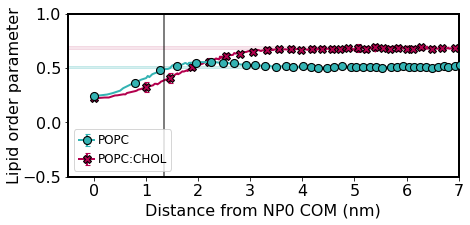

In [25]:
Z=16
every = 7
fig = plt.figure(figsize=(7,3))
ax = plt.axes()
ax.set_xlim(-0.5,7)
ax.set_ylim(-0.5,1.0)
ax.set_yticks([-0.5,0.0,0.5,1.0])
ax.set_xticks(range(8))
ax.tick_params(labelsize=Z)
ax.set_xlabel("Distance from NP0 COM (nm)", fontsize=Z)
ax.set_ylabel("Lipid order parameter", fontsize=Z, labelpad=0.1)
ax.fill_between([-0.5,7],0.512-0.007, 0.512+0.007, color=(0.2,0.7,0.7), alpha=0.2)
ax.fill_between([-0.5,7],0.687-0.015, 0.687+0.015, color=(0.7,0.0,0.3), alpha=0.1)
ax.axvline(1.35, lw=2, c='k', alpha=0.5)
ax.errorbar(n05_ord_r[0], n05_ord_r[1], yerr=n05_ord_r[2], mew=1.1, markevery=every, errorevery=every, fmt='-o', ms=8, lw=2, mec='k', color=(0.2,0.7,0.7), capsize=2.5, label='POPC', zorder=10)
ax.errorbar(n06_ord_r[0], n06_ord_r[1], yerr=n06_ord_r[2], mew=1.1, markevery=every+6, errorevery=every+6, fmt='-X', ms=8, lw=2, mec='k', color=(0.7,0.0,0.3), capsize=2.5, label='POPC:CHOL', zorder=1)
ax.legend(fontsize=Z-4, mode='expand', bbox_to_anchor=(0., 0.,0.28,0.6), loc='lower left', framealpha=0.8, handletextpad=0.3, handlelength=1.3)
plt.savefig("Plots/NP0_order.png", format='png', dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("Plots/NP0_order.svg", format='svg', bbox_inches='tight')
svg2emf("Plots/NP0_order.svg")
plt.show()
plt.close()

In [21]:
n15_pt_ord, n15_pt_ord_std = read_text_order_xy_map("ORDER/NP61-POPC5-46_PRO1-3_Pt_order_xy.sfu", tini=2895000, tfin=3000000, dt=3600, L=15)
n162_pt_ord, n162_pt_ord_std = read_text_order_xy_map("ORDER/NP61-POPC6-46_PRO1_Pt_order_xy.sfu", tini=864000, tfin=1000000, dt=3600, L=12)

Done with ORDER/NP61-POPC5-46_PRO1-3_Pt_order_xy.sfu
Done with ORDER/NP61-POPC6-46_PRO1_Pt_order_xy.sfu


In [29]:
print("POPC -> gHNP-local")
n15_pt_means, n15_pt_stds = average_multimap(n15_pt_ord, 6)
print("POPC:CHOL -> gHNP-local (Binding mode 2)")
n162_pt_means, n162_pt_stds = average_multimap(n162_pt_ord, 6)

POPC -> gHNP-local
0.688 +/- 0.047
0.525 +/- 0.063
0.544 +/- 0.086
0.4 +/- 0.1
0.647 +/- 0.055
0.596 +/- 0.099
0.582 +/- 0.134
0.462 +/- 0.123
POPC:CHOL -> gHNP-local (Binding mode 2)
0.619 +/- 0.087
0.553 +/- 0.115
0.582 +/- 0.077
0.438 +/- 0.089
0.558 +/- 0.116
0.614 +/- 0.102
0.664 +/- 0.067
0.55 +/- 0.059


In [30]:
n12_pt_ords = [n15_pt_ord, n162_pt_ord]

gHNP with/without cholesterol (Binding mode 2) (Pt centered)


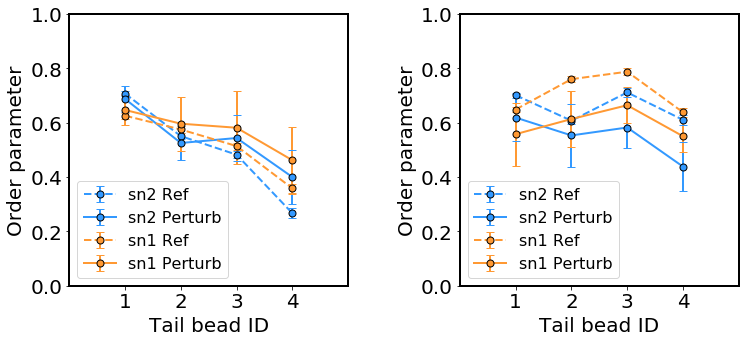

In [31]:
print("gHNP with/without cholesterol (Binding mode 2) (Pt centered)")
plot_order_bead([p5_means, p6_means], [p5_stds, p6_stds], [n15_pt_means, n162_pt_means], [n15_pt_stds, n162_pt_stds])

gHNP with/without cholesterol (Binding mode 2) (Pt centered)


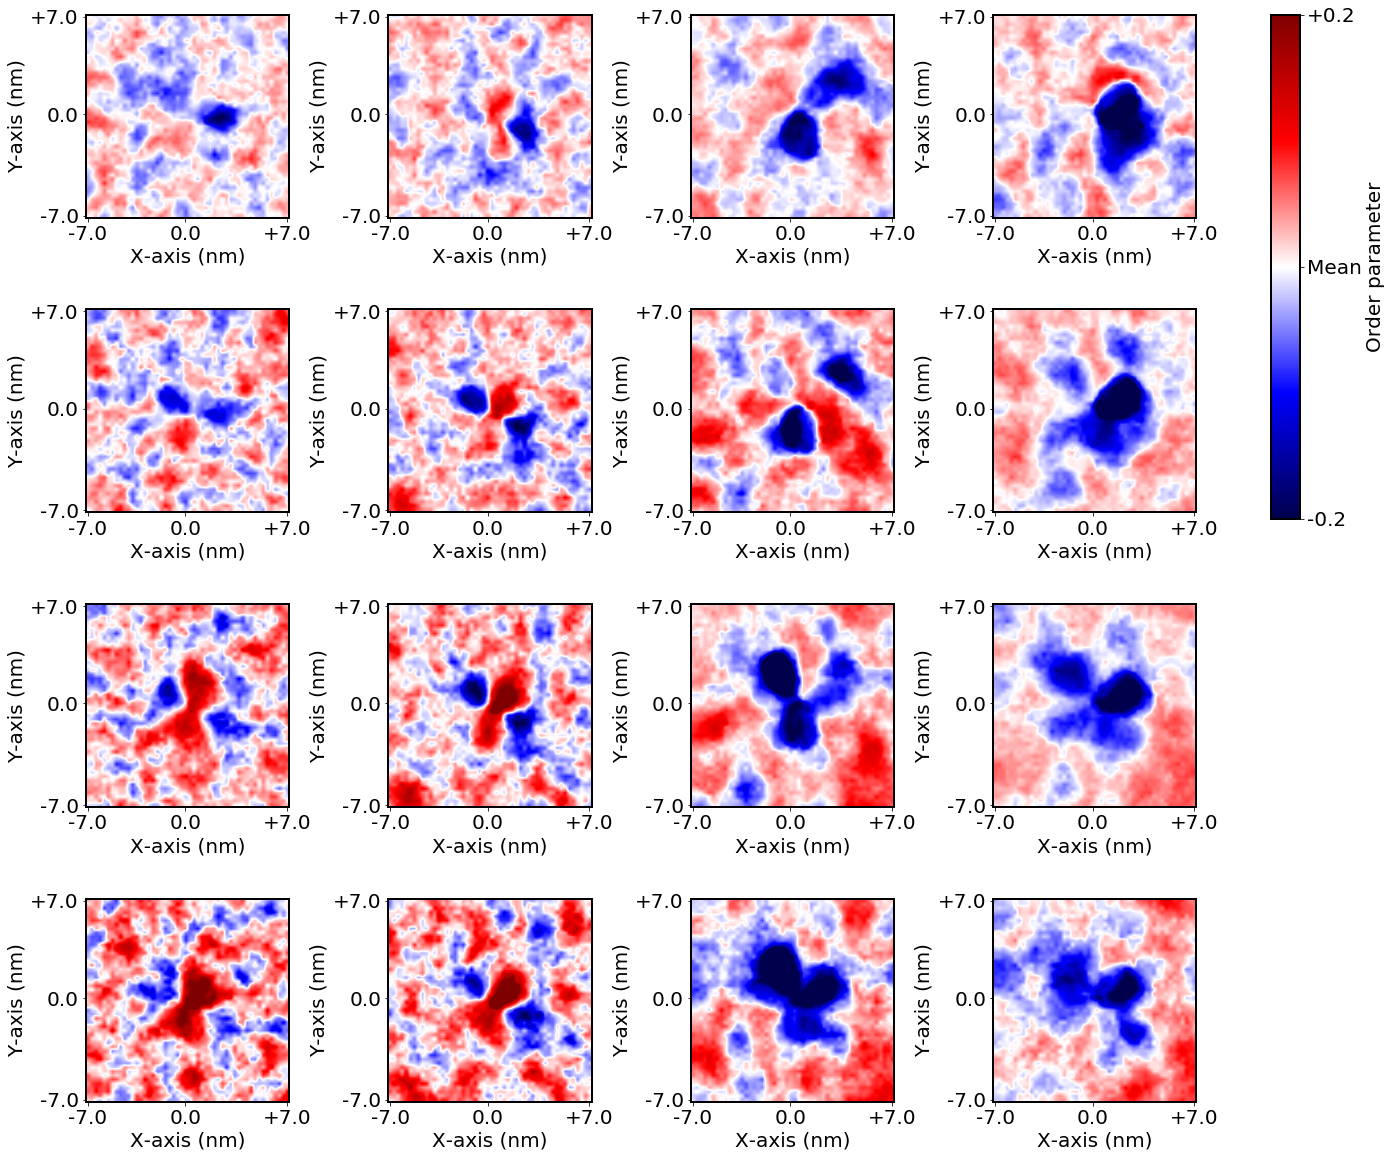

In [32]:
print("gHNP with/without cholesterol (Binding mode 2) (Pt centered)")
plot_order(n12_pt_ords, [p5_means, p6_means])

0.510 +/- 0.133
0.683 +/- 0.063


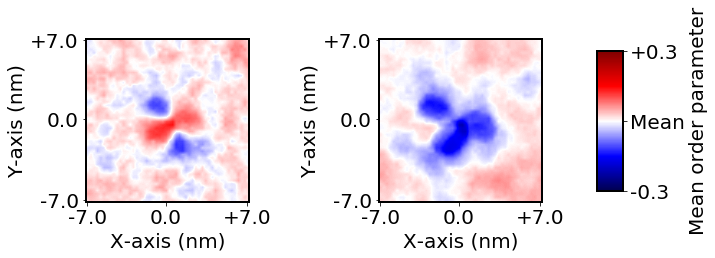

In [33]:
plot_order_mean(n12_pt_ords, [p5_means, p6_means], delta = 0.32, fname='gHNP', cmap='seismic')

In [28]:
n15_ptopp_ord, n15_ptopp_ord_std = read_text_order_xy_map("ORDER/NP61-POPC5-46_PRO1-3_Ptopp_order_xy.sfu", tini=2895000, tfin=3000000, dt=3600, L=15)
n162_ptopp_ord, n162_ptopp_ord_std = read_text_order_xy_map("ORDER/NP61-POPC6-46_PRO1_Ptopp_order_xy.sfu", tini=864000, tfin=1000000, dt=3600, L=12)

Done with ORDER/NP61-POPC5-46_PRO1-3_Ptopp_order_xy.sfu
Done with ORDER/NP61-POPC6-46_PRO1_Ptopp_order_xy.sfu


In [34]:
print("POPC -> gHNP-local")
n15_ptopp_means, n15_ptopp_stds = average_multimap(n15_ptopp_ord, 6)
print("POPC:CHOL -> gHNP-local (Binding mode 2)")
n162_ptopp_means, n162_ptopp_stds = average_multimap(n162_ptopp_ord, 6)

POPC -> gHNP-local
0.699 +/- 0.023
0.551 +/- 0.041
0.423 +/- 0.06
0.152 +/- 0.065
0.612 +/- 0.029
0.526 +/- 0.043
0.421 +/- 0.06
0.24 +/- 0.088
POPC:CHOL -> gHNP-local (Binding mode 2)
0.7 +/- 0.016
0.565 +/- 0.035
0.527 +/- 0.047
0.397 +/- 0.048
0.603 +/- 0.036
0.644 +/- 0.038
0.638 +/- 0.043
0.464 +/- 0.051


In [37]:
n12_ptopp_ords = [n15_ptopp_ord, n162_ptopp_ord]

gHNP with/without cholesterol (Binding mode 2) (Pt centered)


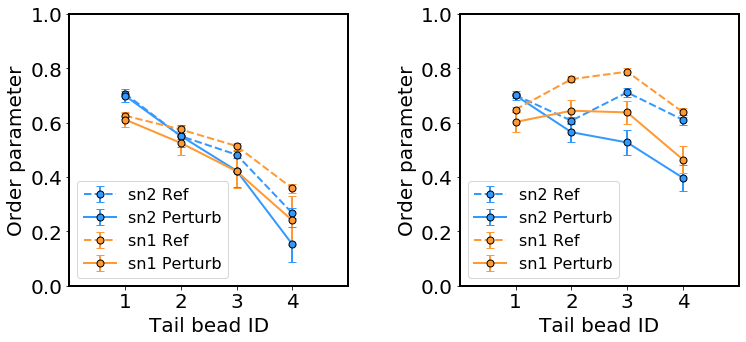

In [35]:
print("gHNP with/without cholesterol (Binding mode 2) (Pt centered)")
plot_order_bead([p5_means, p6_means], [p5_stds, p6_stds], [n15_ptopp_means, n162_ptopp_means], [n15_ptopp_stds, n162_ptopp_stds])

gHNP with/without cholesterol (Binding mode 2) (Pt centered)


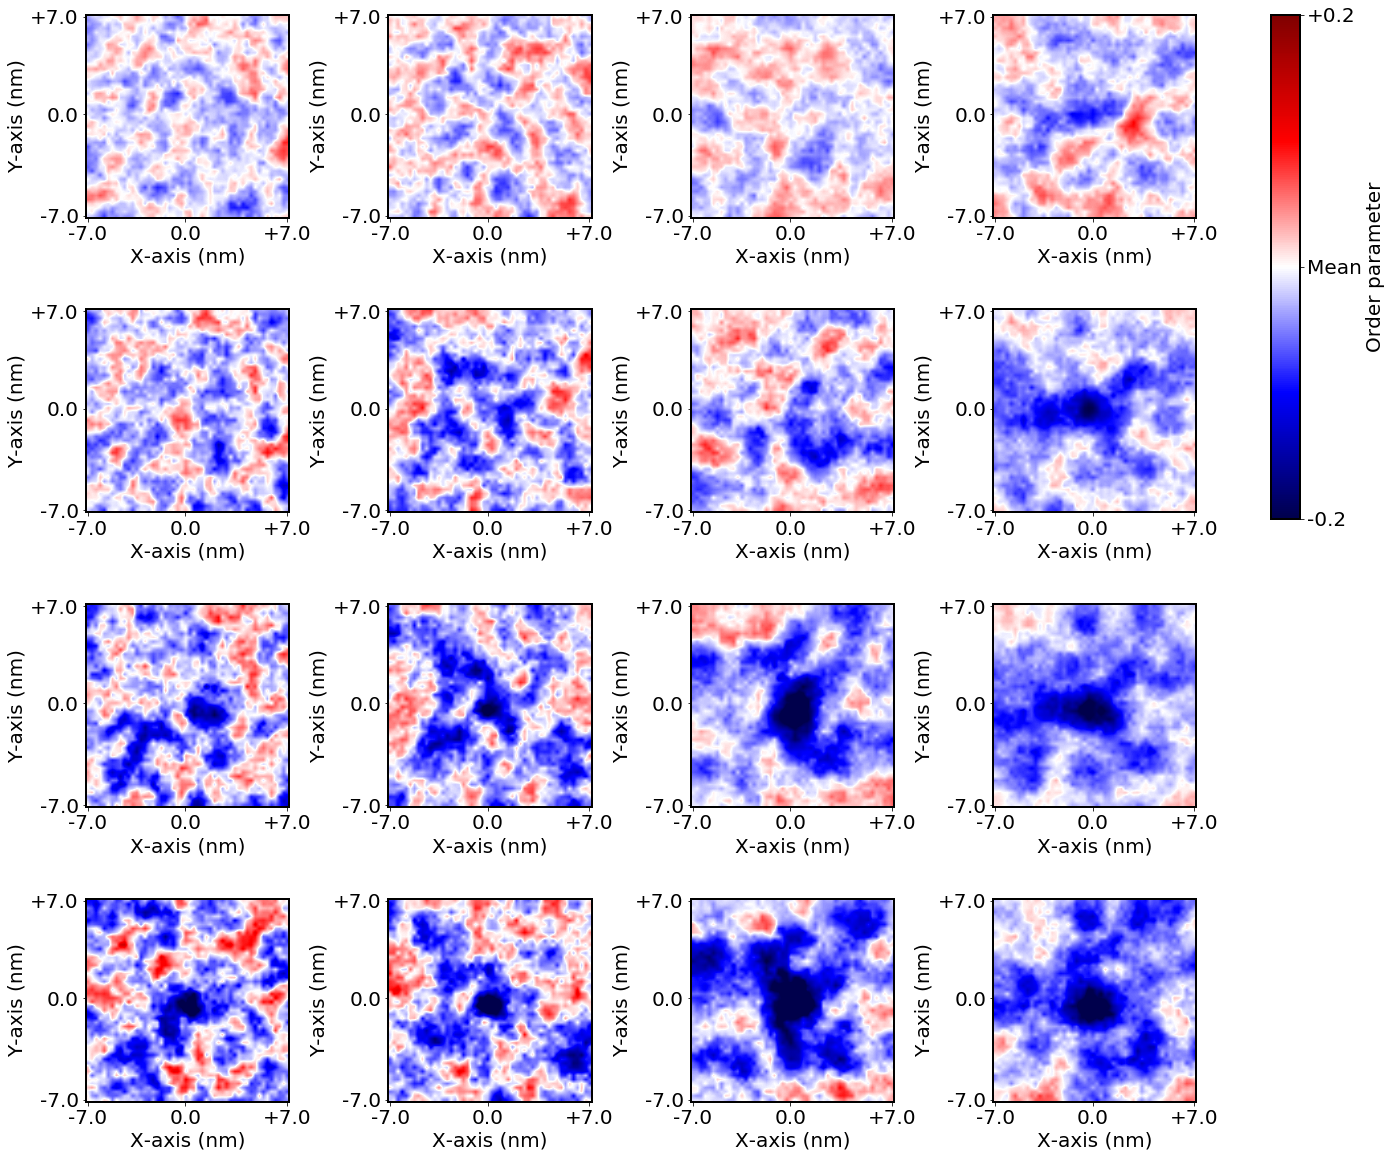

In [38]:
print("gHNP with/without cholesterol (Binding mode 2) (Pt centered)")
plot_order(n12_ptopp_ords, [p5_means, p6_means])

0.510 +/- 0.133
0.683 +/- 0.063


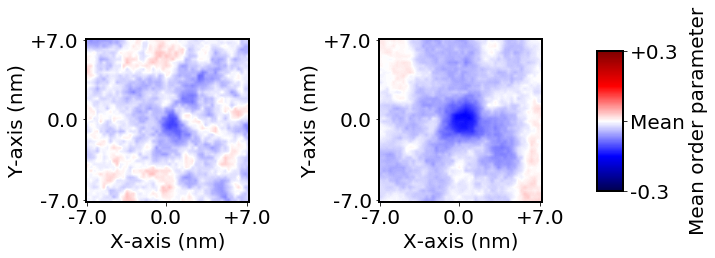

In [39]:
plot_order_mean(n12_ptopp_ords, [p5_means, p6_means], delta = 0.32, fname='gHNP', cmap='seismic')